In [8]:
# Con este Notebook se realizará la carga y procesado de registros logs de la arquitectura
#   de microservicios desarrollada en docker para el sistema de información ADSB
#   Se extrae la información de memria de los contenedores en cada test, se especifican los de interés y se analizan

In [9]:
# Importación de librerías necesarias
import os
import re
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# Configuración previa para tratar los archivos

carpeta_logs = "./recursos_test/"  # Cambia si tus archivos están en otra carpeta
contenedores_objetivo = ["redis", "kafka"]  # Nombres exactos que aparecerán en la columna NAME

# extraer nombre y memoria usada en MiB 
regex_memoria = re.compile(r'(?P<id>\S+)\s+(?P<name>\S+)\s+\S+\s+(?P<mem>[\d\.]+)MiB')

# Tamaño del intervalo (número de muestras por bloque)
tam_bloque = 5


In [11]:
# Función auxiliar para procesar las métricas de interes
def extraer_memoria_por_contenedor(archivo):
    with open(archivo, 'r') as f:
        lineas = f.readlines()

    datos = {nombre: [] for nombre in contenedores_objetivo}
    bloque = []

    for linea in lineas:
        if "CONTAINER ID" in linea:
            if bloque:
                for l in bloque:
                    match = regex_memoria.search(l)
                    if match:
                        name = match.group('name')
                        mem = float(match.group('mem'))
                        if name in contenedores_objetivo:
                            datos[name].append(mem)
                bloque = []
        else:
            bloque.append(linea)

    for l in bloque:
        match = regex_memoria.search(l)
        if match:
            name = match.group('name')
            mem = float(match.group('mem'))
            if name in contenedores_objetivo:
                datos[name].append(mem)

    return datos


In [12]:
# Carga de archivos, proceso para separar las líneas de interés y almacenarlas 
archivos = sorted([f for f in os.listdir(carpeta_logs) if f.startswith("recursos") and f.endswith(".log")])
resultados_mem = {nombre: {} for nombre in contenedores_objetivo}

for archivo in archivos:
    test_id = os.path.splitext(archivo)[0]
    datos = extraer_memoria_por_contenedor(os.path.join(carpeta_logs, archivo))
    for nombre in contenedores_objetivo:
        resultados_mem[nombre][test_id] = datos.get(nombre, [])


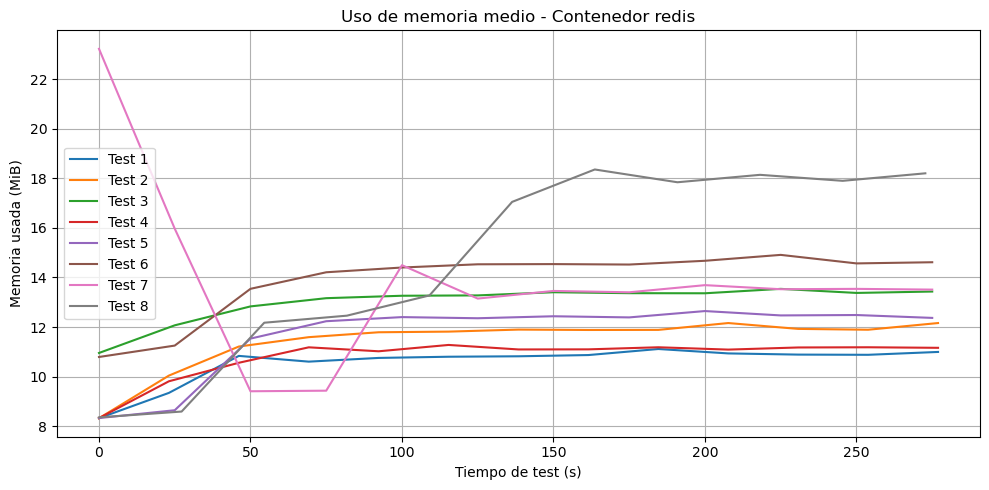

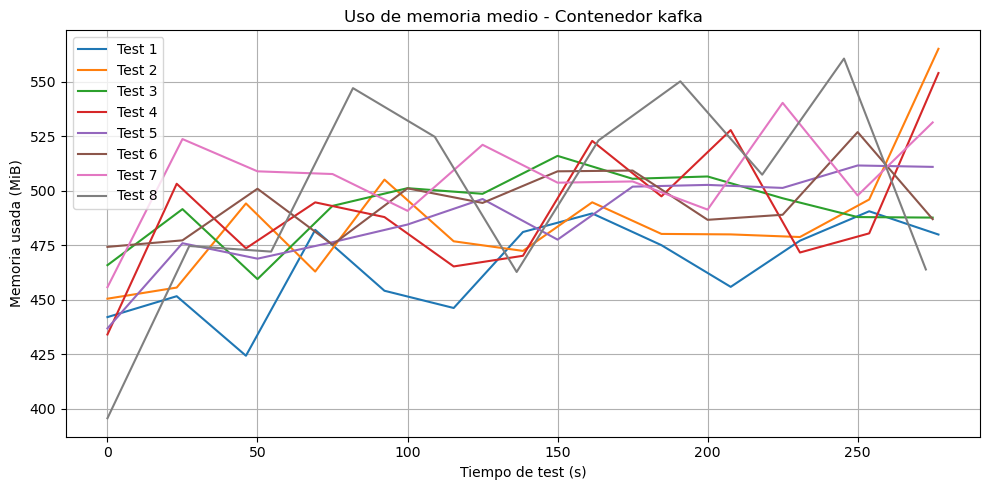

In [13]:
# Agrupar la información y presentarla gráficamente
# Se realiza un escalado de las muestras adapatada al tiempo de test, según TEST.sh es de 300 segundos

for nombre in contenedores_objetivo:
    plt.figure(figsize=(10, 5))
    for test_id, valores in resultados_mem[nombre].items():
        medias = [sum(valores[i:i+tam_bloque]) / len(valores[i:i+tam_bloque])
                  for i in range(0, len(valores), tam_bloque)
                  if len(valores[i:i+tam_bloque]) > 0]
        test_num = int(re.search(r'recursos(\d+)', test_id).group(1))
        escala_muestras=300/len(medias)
        eje_x = [i * escala_muestras for i in range(len(medias))]
        plt.plot(eje_x, medias, label=f"Test {test_num}")


    plt.title(f"Uso de memoria medio - Contenedor {nombre}")
    plt.xlabel(f"Tiempo de test (s)")
    plt.ylabel("Memoria usada (MiB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()